# Handwriting Recognition Training (Google Colab GPU)
## CNN-BiLSTM-CTC Model on IAM Dataset

**Runtime:** GPU (Runtime → Change runtime type → GPU)

## 1. Setup & Installations

In [1]:
# Install required packages
!pip install -q datasets transformers jiwer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from PIL import Image
from tqdm import tqdm
from jiwer import cer, wer
import matplotlib.pyplot as plt

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 107.4 MB/s eta 0:00:00
✓ Using device: cuda
  GPU: NVIDIA A100-SXM4-40GB
  Memory: 42.47 GB


## 2. Model Architecture

In [2]:
class CRNN(nn.Module):
    """CNN-BiLSTM-CTC for Handwriting Recognition"""

    def __init__(self, img_height=128, num_chars=80, hidden_size=256, num_layers=2):
        super(CRNN, self).__init__()

        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(512, 512, 2), nn.BatchNorm2d(512), nn.ReLU(),
        )

        self.map2seq = nn.Linear(512 * 7, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, bidirectional=True,
                           dropout=0.3 if num_layers > 1 else 0, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)

    def forward(self, x):
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        conv = conv.permute(0, 3, 1, 2).reshape(b, w, c * h)
        seq = self.map2seq(conv)
        rnn_out, _ = self.rnn(seq)
        output = self.fc(rnn_out)
        return torch.nn.functional.log_softmax(output, dim=2)

print("✓ Model architecture defined")

✓ Model architecture defined


## 3. Character Mapper

In [3]:
class CharacterMapper:
    def __init__(self):
        chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,;:!?\'"()-')
        self.chars = sorted(list(chars))
        self.char2idx = {c: i+1 for i, c in enumerate(self.chars)}
        self.idx2char = {i+1: c for i, c in enumerate(self.chars)}
        self.idx2char[0] = ''  # CTC blank
        self.num_classes = len(self.chars) + 1

    def encode(self, text):
        return [self.char2idx[c] for c in text if c in self.char2idx]

    def decode(self, indices):
        chars, prev = [], None
        for idx in indices:
            if idx != 0 and idx != prev and idx in self.idx2char:
                chars.append(self.idx2char[idx])
            prev = idx
        return ''.join(chars)

char_mapper = CharacterMapper()
print(f"✓ Character mapper: {char_mapper.num_classes} classes")

✓ Character mapper: 75 classes


## 4. Dataset & DataLoader

In [4]:
class IAMDataset(Dataset):
    def __init__(self, split='train', img_height=128):
        self.img_height = img_height
        self.dataset = load_dataset("Teklia/IAM-line", split=split)
        print(f"  Loaded {len(self.dataset)} samples")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        img = sample['image'].convert('L')
        text = sample['text']

        # Resize
        w, h = img.size
        new_w = int(self.img_height * (w / h))
        img = img.resize((new_w, self.img_height), Image.Resampling.LANCZOS)

        # Normalize
        img = np.array(img, dtype=np.float32) / 255.0
        img = (img - 0.5) / 0.5
        img = torch.FloatTensor(img).unsqueeze(0)

        target = torch.LongTensor(char_mapper.encode(text))
        return img, target, len(target), text

def collate_fn(batch):
    # Filter out samples with empty targets before processing the batch
    filtered_batch = [item for item in batch if item[1].numel() > 0]

    if not filtered_batch:
        # If all samples in the batch resulted in empty targets, return empty tensors
        # This batch will effectively be skipped by the DataLoader downstream without error.
        return {
            'images': torch.empty(0),
            'targets': torch.empty(0, dtype=torch.long),
            'target_lengths': torch.empty(0, dtype=torch.long),
            'input_lengths': torch.empty(0, dtype=torch.long),
            'texts': []
        }

    images, targets, target_lengths, texts = zip(*filtered_batch)

    max_w = max(img.shape[2] for img in images)
    b, h = len(images), images[0].shape[1]

    padded_imgs = torch.zeros(b, 1, h, max_w)
    input_lengths = []

    for i, img in enumerate(images):
        w = img.shape[2]
        padded_imgs[i, :, :, :w] = img
        # Ensure input_length is at least 1, as CTC expects non-zero length
        # and (w // 4) - 1 can be 0 or negative for very small images.
        input_lengths.append(max(1, (w // 4) - 1))

    return {
        'images': padded_imgs,
        'targets': torch.cat(targets), # Now all targets in 'targets' will be non-empty
        'target_lengths': torch.LongTensor(target_lengths),
        'input_lengths': torch.LongTensor(input_lengths),
        'texts': texts
    }

print("Loading datasets...")
train_dataset = IAMDataset('train')
val_dataset = IAMDataset('validation')

# Adjust batch_size to resolve OutOfMemoryError
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"✓ Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Loading datasets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

data/validation.parquet:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

data/test.parquet:   0%|          | 0.00/73.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6482 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/976 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2915 [00:00<?, ? examples/s]

  Loaded 6482 samples
  Loaded 976 samples
✓ Train batches: 811, Val batches: 122


## 5. Training Functions

In [5]:
def decode_predictions(outputs, char_mapper):
    _, max_indices = torch.max(outputs, dim=2)
    return [char_mapper.decode(idx.cpu().numpy().tolist()) for idx in max_indices]

def compute_metrics(preds, truths):
    # Filter out empty ground truths as jiwer handles empty predictions but needs non-empty truths
    # Also, ensure predictions are not None
    valid_pairs = []
    for p, g in zip(preds, truths):
        if g: # Only include if ground truth is not empty
            valid_pairs.append((p if p else "", g)) # Use empty string for empty predictions

    if not valid_pairs:
        return 0.0, 0.0 # Return 0,0 if no valid pairs to compare (e.g., all ground truths were empty)

    preds_filtered, truths_filtered = zip(*valid_pairs)
    try:
        return cer(list(truths_filtered), list(preds_filtered)), wer(list(truths_filtered), list(preds_filtered))
    except: # Fallback for unexpected errors during metric computation
        return 0.0, 0.0

def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch}")

    for batch in pbar:
        images = batch['images'].to(device)
        targets = batch['targets'].to(device)
        input_lengths = batch['input_lengths']
        target_lengths = batch['target_lengths']

        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)  # CTC format

        loss = criterion(outputs, targets, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_truths = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            images = batch['images'].to(device)
            targets = batch['targets'].to(device)
            input_lengths = batch['input_lengths']
            target_lengths = batch['target_lengths']
            texts = batch['texts']

            outputs = model(images)
            outputs_ctc = outputs.permute(1, 0, 2)
            loss = criterion(outputs_ctc, targets, input_lengths, target_lengths)
            total_loss += loss.item()

            preds = decode_predictions(outputs, char_mapper)
            all_preds.extend(preds)
            all_truths.extend(texts)

    avg_loss = total_loss / len(loader)
    cer_score, wer_score = compute_metrics(all_preds, all_truths)

    # Show examples
    print("\nExample predictions:")
    for i in range(min(3, len(all_preds))):
        print(f"  GT:   {all_truths[i]}")
        print(f"  Pred: {all_preds[i]}")

    return avg_loss, cer_score, wer_score

print("✓ Training functions ready")

✓ Training functions ready


## 6. Train Model

In [6]:
# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.001

# Create model
model = CRNN(img_height=128, num_chars=len(char_mapper.chars), hidden_size=256, num_layers=2)
model = model.to(device)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

# Loss & Optimizer
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_cer': [], 'val_wer': []}
best_cer = float('inf')

print(f"\n{'='*60}")
print(f"Starting training: {EPOCHS} epochs")
print(f"{'='*60}\n")

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print("-" * 60)

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")

    # Validate
    val_loss, val_cer, val_wer = validate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, CER: {val_cer:.4f}, WER: {val_wer:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_cer'].append(val_cer)
    history['val_wer'].append(val_wer)

    # Scheduler
    scheduler.step(val_loss)

    # Save best
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_cer': val_cer,
            'val_wer': val_wer,
            'char_mapper': char_mapper,
        }, 'best_model.pth')
        print(f"✓ Saved best model (CER: {val_cer:.4f})")

print(f"\n{'='*60}")
print(f"Training Complete! Best CER: {best_cer:.4f}")
print(f"{'='*60}")

Model: 9,139,147 parameters

Starting training: 10 epochs


Epoch 1/10
------------------------------------------------------------


Epoch 1: 100%|██████████| 811/811 [02:07<00:00,  6.38it/s, loss=2.4214]


Train Loss: 3.2065


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.05it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: 
  GT:   part . The rest of the cast were well chosen ,
  Pred: 
Val Loss: 2.6728, CER: 1.0000, WER: 1.0000
✓ Saved best model (CER: 1.0000)

Epoch 2/10
------------------------------------------------------------


Epoch 2: 100%|██████████| 811/811 [02:03<00:00,  6.58it/s, loss=1.7814]


Train Loss: 1.6866


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.50it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: th was a gplandid inlgrelilion f that   
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: gpalhte C. Thul taomnan game anothed   
  GT:   part . The rest of the cast were well chosen ,
  Pred: pit . The int f the at wee well choren .f 
Val Loss: 1.0331, CER: 0.2927, WER: 0.7179
✓ Saved best model (CER: 0.2927)

Epoch 3/10
------------------------------------------------------------


Epoch 3: 100%|██████████| 811/811 [02:03<00:00,  6.57it/s, loss=0.7922]


Train Loss: 0.9309


Validating: 100%|██████████| 122/122 [00:05<00:00, 20.95it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: th was a plendid inlpretition f that 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: ypathcte C b. Shl bianeman gare ancthaf 
  GT:   part . The rest of the cast were well chosen ,
  Pred: pit . The nit of the cait weie ell choden .f 
Val Loss: 0.7505, CER: 0.2216, WER: 0.6354
✓ Saved best model (CER: 0.2216)

Epoch 4/10
------------------------------------------------------------


Epoch 4: 100%|██████████| 811/811 [02:03<00:00,  6.57it/s, loss=0.6035]


Train Loss: 0.7023


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.35it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: I wwas a splendid imlprettion of that!  
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: wympathctie ( G . Shaul abianoman gae anothr!  ?
  GT:   part . The rest of the cast were well chosen ,
  Pred: pait . "he nit of the cat were well chosen ,!; 
Val Loss: 0.6217, CER: 0.2118, WER: 0.5687
✓ Saved best model (CER: 0.2118)

Epoch 5/10
------------------------------------------------------------


Epoch 5: 100%|██████████| 811/811 [02:03<00:00,  6.56it/s, loss=0.4834]


Train Loss: 0.6004


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.44it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: It wwas a splendid imleupretition of thatf . 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: sympathete C G. Shaul afamoman gare anotherf . 
  GT:   part . The rest of the cast were well chosen ,
  Pred: pait . The nit of the cait wee well chosern .)
Val Loss: 0.5655, CER: 0.1772, WER: 0.5306
✓ Saved best model (CER: 0.1772)

Epoch 6/10
------------------------------------------------------------


Epoch 6: 100%|██████████| 811/811 [02:03<00:00,  6.57it/s, loss=0.7333]


Train Loss: 0.5343


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.38it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: It wwas a splendid intexpretition of thatf.
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: syrmpathetie C 0. Shoul afameman gare anothedf .
  GT:   part . The rest of the cast were well chosen ,
  Pred: pat . The nit of the cait wexe wwell chosen ,f.
Val Loss: 0.4963, CER: 0.1582, WER: 0.4874
✓ Saved best model (CER: 0.1582)

Epoch 7/10
------------------------------------------------------------


Epoch 7: 100%|██████████| 811/811 [02:03<00:00,  6.59it/s, loss=0.1274]


Train Loss: 0.4868


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.36it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: I was a splondid imteorpretation of thatf 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: symgathetie CD. Saul aGamoman gare anotherf  
  GT:   part . The rest of the cast were well chosen ,
  Pred: pait . The rit of the cast were well chosen .f ,
Val Loss: 0.4595, CER: 0.1439, WER: 0.4647
✓ Saved best model (CER: 0.1439)

Epoch 8/10
------------------------------------------------------------


Epoch 8: 100%|██████████| 811/811 [02:03<00:00,  6.56it/s, loss=0.7560]


Train Loss: 0.4466


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.39it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: Ih was a plondid intrpetatiion of thatf
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: sympathetic C O. Paul bamoman gare anothenf
  GT:   part . The rest of the cast were well chosen ,
  Pred: pait . " The nit of the cast wee well choson .f
Val Loss: 0.4519, CER: 0.1435, WER: 0.4725
✓ Saved best model (CER: 0.1435)

Epoch 9/10
------------------------------------------------------------


Epoch 9: 100%|██████████| 811/811 [02:03<00:00,  6.58it/s, loss=0.2007]


Train Loss: 0.4232


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.44it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: Ih was a solendid intergretation of thatf 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: supmpathetie ( O. Pul bamemanm gare anatherf 
  GT:   part . The rest of the cast were well chosen ,
  Pred: pait . The neit of the cast were well chosen .). 
Val Loss: 0.4316, CER: 0.1392, WER: 0.4421
✓ Saved best model (CER: 0.1392)

Epoch 10/10
------------------------------------------------------------


Epoch 10: 100%|██████████| 811/811 [02:03<00:00,  6.57it/s, loss=0.4723]


Train Loss: 0.3923


Validating: 100%|██████████| 122/122 [00:05<00:00, 21.28it/s]



Example predictions:
  GT:   It was a splendid interpretation of the
  Pred: It was a splendid inteyetation of thatf 
  GT:   sympathetic C O . Paul Daneman gave another
  Pred: sympathetie CD. Sul abameman gave anotherf 
  GT:   part . The rest of the cast were well chosen ,
  Pred: pat . The nit of the cast were well chosen .f .
Val Loss: 0.3836, CER: 0.1295, WER: 0.4247
✓ Saved best model (CER: 0.1295)

Training Complete! Best CER: 0.1295


## 7. Plot Training History

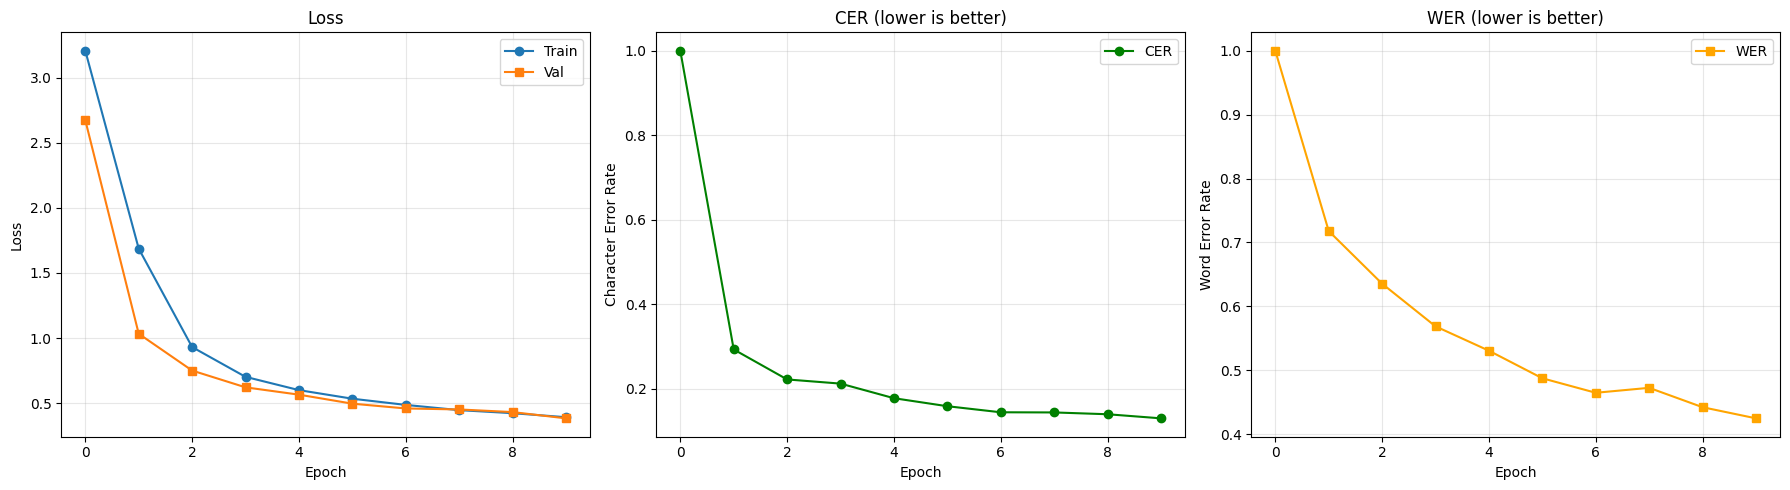

✓ Final metrics: CER=0.1295, WER=0.4247


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# CER
axes[1].plot(history['val_cer'], label='CER', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Character Error Rate')
axes[1].set_title('CER (lower is better)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# WER
axes[2].plot(history['val_wer'], label='WER', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Word Error Rate')
axes[2].set_title('WER (lower is better)')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print(f"✓ Final metrics: CER={history['val_cer'][-1]:.4f}, WER={history['val_wer'][-1]:.4f}")

## 8. Inference / Prediction

✓ Loaded best model (Epoch 10, CER: 0.1295)


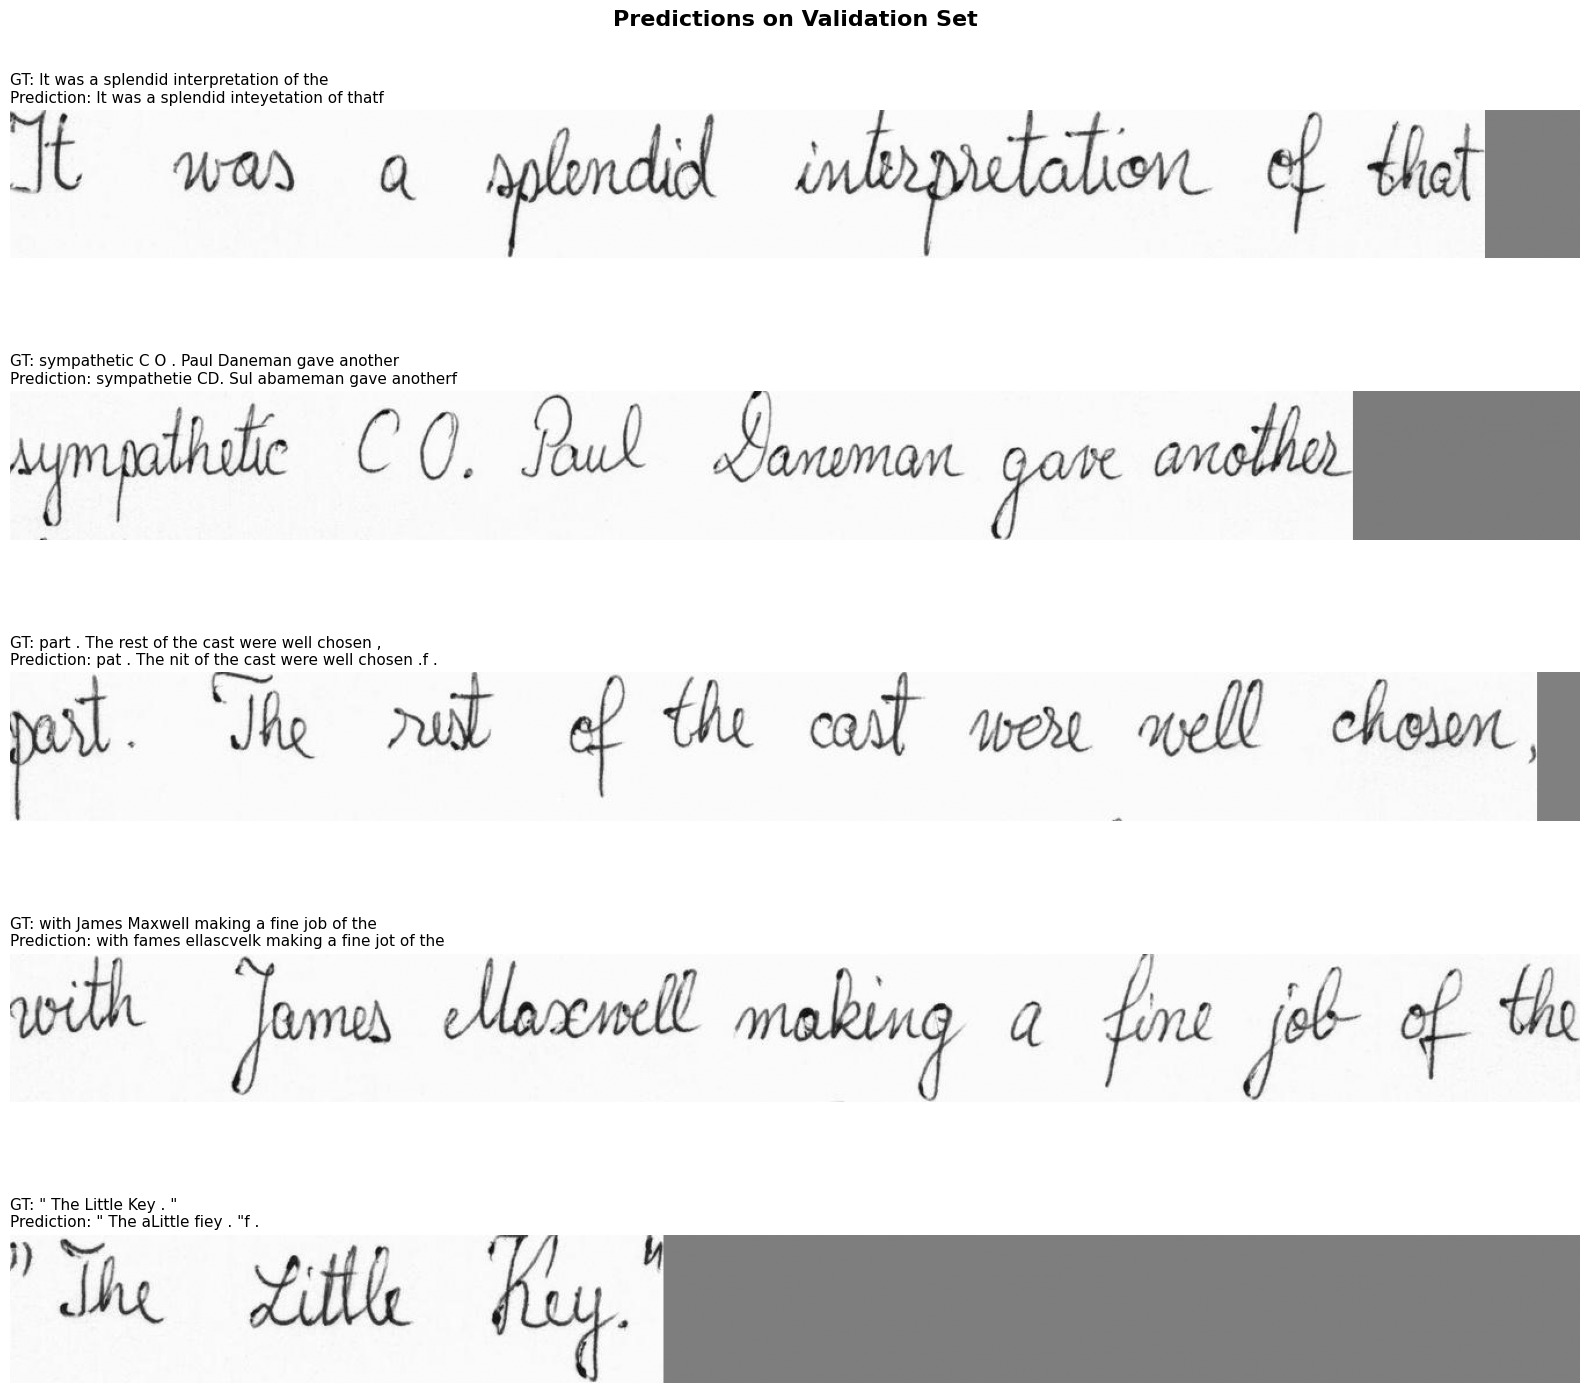


✓ Predictions saved to 'predictions.png'


In [14]:
if not os.path.exists('best_model.pth'):
    print("❌ Error: best_model.pth not found!")
    print("   Please either:")
    print("   1. Upload the model using the cell above, OR")
    print("   2. Run the training cells to generate the model")
else:
    # Load checkpoint - weights_only=False is safe here since this is your own checkpoint
    checkpoint = torch.load('best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"✓ Loaded best model (Epoch {checkpoint['epoch']}, CER: {checkpoint['val_cer']:.4f})")

    # Test on validation samples
    test_batch = next(iter(val_loader))

    with torch.no_grad():
        images = test_batch['images'].to(device)
        outputs = model(images)
        predictions = decode_predictions(outputs, char_mapper)

    # Visualize predictions
    fig, axes = plt.subplots(5, 1, figsize=(16, 15))

    for i in range(5):
        img = test_batch['images'][i, 0].cpu().numpy()
        img = (img * 0.5) + 0.5  # Denormalize

        gt = test_batch['texts'][i]
        pred = predictions[i]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"GT: {gt}\nPrediction: {pred}", fontsize=11, loc='left')
        axes[i].axis('off')

    plt.suptitle('Predictions on Validation Set', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150)
    plt.show()

    print("\n✓ Predictions saved to 'predictions.png'")


## 9. Download Model (Optional)

In [10]:
# Download model to local machine
from google.colab import files

print("Downloading model...")
files.download('best_model.pth')
print("\n✓ Model downloaded! Use it for deployment.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Model downloaded! Use it for deployment.
